# CGAN手写数字Pytorch实现
- @author: shenhao0223sh@gmail.com
- Date: 2021.10.22

In [1]:
from google.colab import drive  # Import a library named google.colab

drive.mount("/content/drive")  # mount the content to the directory `/content/drive`

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters
num_epochs = 50
batch_size = 100
sample_dir = "cgan_samples"

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.5)]
)

# MNIST dataset
mnist = torchvision.datasets.MNIST(
    "./data", train=True, transform=transform, download=True
)

# Data loader
data_loader = torch.utils.data.DataLoader(
    dataset=mnist, batch_size=batch_size, shuffle=True
)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)
        # Embedding类返回的是一个形状为[每句词个数， 词维度]的矩阵。
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()
        # 可以删除数组形状中的单维度条目，即把shape中为1的维度去掉，但是对非单维的维度不起作用。

Epoch [0/50], Step [200/600], d_loss: 0.3582, g_loss: 2.8870, D(x): 0.91, D(G(z)): 0.30
Epoch [0/50], Step [400/600], d_loss: 0.9237, g_loss: 1.8394, D(x): 0.63, D(G(z)): 0.71
Epoch [0/50], Step [600/600], d_loss: 0.7758, g_loss: 1.7735, D(x): 0.59, D(G(z)): 0.70
Epoch [1/50], Step [200/600], d_loss: 2.1853, g_loss: 0.7672, D(x): 0.44, D(G(z)): 0.62
Epoch [1/50], Step [400/600], d_loss: 0.5846, g_loss: 1.8735, D(x): 0.82, D(G(z)): 0.52
Epoch [1/50], Step [600/600], d_loss: 0.6344, g_loss: 1.1730, D(x): 0.90, D(G(z)): 0.24
Epoch [2/50], Step [200/600], d_loss: 1.1602, g_loss: 1.8866, D(x): 0.72, D(G(z)): 0.58
Epoch [2/50], Step [400/600], d_loss: 0.6413, g_loss: 2.3737, D(x): 0.81, D(G(z)): 0.74
Epoch [2/50], Step [600/600], d_loss: 0.5713, g_loss: 2.3937, D(x): 0.83, D(G(z)): 0.72
Epoch [3/50], Step [200/600], d_loss: 0.3168, g_loss: 3.8283, D(x): 0.88, D(G(z)): 0.65
Epoch [3/50], Step [400/600], d_loss: 0.2783, g_loss: 3.7121, D(x): 0.93, D(G(z)): 0.68
Epoch [3/50], Step [600/600], d_

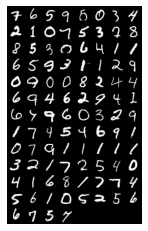

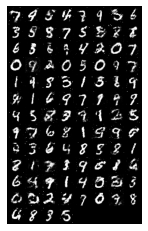

(-0.5, 301.5, 301.5, -0.5)

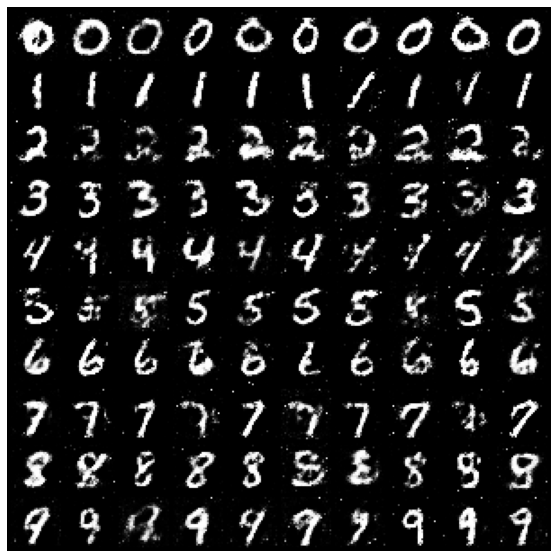

In [6]:
G = Generator().to(device)
D = Discriminator().to(device)
# 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)

# Clamp函数x限制在区间[min, max]内
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


# 开始训练
total_step = len(data_loader)


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        step = epoch * len(data_loader) + i + 1
        images = images.to(device)
        labels = labels.to(device)
        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size).to(device)  # 真标签全是1
        fake_labels = torch.randint(0, 10, (batch_size,)).to(
            device
        )  ##返回均匀分布的[0,10]之间的整数随机值
        # ================================================================== #
        #                      训练判别器                                    #
        # ================================================================== #

        # 定义判断器对真图片的损失函数
        real_validity = D(images, labels)
        d_loss_real = criterion(real_validity, real_labels)  # 损失比较，与1
        real_score = real_validity  # 判别器生成的值
        # 定义判别器对假图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size, 100).to(device)
        # 创建batch_size行100列的随机数的tensor，随机值的分布式均值为0，方差为1
        fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
        # 创建batch_size行列不指定的随机整数的tensor，随机值的区间是[low, high)[0,10]
        fake_images = G(z, fake_labels)
        fake_validity = D(fake_images, fake_labels)

        d_loss_fake = criterion(
            fake_validity, torch.zeros(batch_size).to(device)
        )  # 损失比较，与0
        fake_score = fake_images  # 生成器生成的值
        d_loss = d_loss_fake + d_loss_real

        # 对生成器、判别器的梯度清零
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        训练生成器                                  #
        # ================================================================== #

        # 定义生成器对假图片的损失函数，这里我们要求
        # 判别器生成的图片越来越像真图片，故损失函数中
        # 的标签改为真图片的标签，即希望生成的假图片，
        # 越来越靠近真图片

        z = torch.randn(batch_size, 100).to(device)
        fake_images = G(z, fake_labels)
        validity = D(fake_images, fake_labels)
        g_loss = criterion(validity, torch.ones(batch_size).to(device))  # 标签为1

        # 对生成器、判别器的梯度清零
        # 进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 200 == 0:
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item() * (-1),
                )
            )
    # 保存真图片
    if (epoch + 1) == 1:  # 只是保存一张
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, "real_images.png"))

    # 保存假图片
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(
        denorm(fake_images),
        os.path.join(sample_dir, "fake_images-{}.png".format(epoch + 1)),
    )

# 保存模型
torch.save(G.state_dict(), "G.ckpt")
torch.save(D.state_dict(), "D.ckpt")
import matplotlib.image as mpimg  # mpimg 用于读取图片
import matplotlib.pyplot as plt  # plt 用于显示图片

reconsPath = "./cgan_samples/real_images.png"
Image = mpimg.imread(reconsPath)
plt.imshow(Image)  # 显示图片
plt.axis("off")  # 不显示坐标轴
plt.show()

reconsPath = "./cgan_samples/fake_images-50.png"
Image = mpimg.imread(reconsPath)
plt.imshow(Image)  # 显示图片
plt.axis("off")  # 不显示坐标轴
plt.show()

from torchvision.utils import make_grid

z = torch.randn(100, 100).to(device)
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)

images = G(z, labels).unsqueeze(1)
grid = make_grid(images, nrow=10, normalize=True)
# make_grid用于把几个图像按照网格排列的方式绘制出来
# 每行的图片数量为10
# normalize如果为True，则把图像的像素值通过range指定的最大值和最小值归一化到0-1。
fig, ax = plt.subplots(figsize=(10, 10))
# fig代表绘图窗口(Figure)；ax代表这个绘图窗口上的坐标系(axis)，一般会继续对ax进行操作。
# 表示figure 的大小为宽、长（单位为inch）
ax.imshow(grid.permute(1, 2, 0).detach().cpu().numpy(), cmap="binary")
# grid.permute(1, 2, 0)将tensor的维度换位，原来的顺序是（0，1，2）
# 当使用detach()分离tensor但是没有更改这个tensor时，并不会影响backward()
# 显示设置，两端发散的色图 colormaps
ax.axis("off")

In [16]:
def generate_digit(generator, digit):
    z = torch.randn(1, 100).to(device)
    label = torch.LongTensor([digit]).to(device)
    img = generator(z, label).detach()
    img = 0.5 * img + 0.5  # 还原图像，反归一化
    return transforms.ToPILImage()(img)


generate_digit(G, 8)

In [17]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9], device='cuda:0')

In [26]:
generate_digit(G, 8)

In [27]:
generate_digit(G, 7)